In [ ]:
using PlotlyJS

# Define 3D point and direction as Vector{Float64}
const Vec3 = Vector{Float64}
const Vec2 = Vector{Float64}
const Point = Vec3
const Direction = Vec3

mutable struct Ray
    origin::Point
    direction::Direction
    amplitude::Float64  # New amplitude property
end

mutable struct TrajectoryNode
    ray::Ray
    children::Vector{TrajectoryNode}
end

mutable struct Trajectory
    root::TrajectoryNode
end

function add_child!(parent::TrajectoryNode, child::Ray)
    push!(parent.children, TrajectoryNode(child, []))
end

# Function to recursively generate rays (simulating reflection/refraction)
function generate_rays!(node::TrajectoryNode, depth::Int, spread_factor::Float64=0.7)
    if depth == 0
        return
    end

    ray = node.ray
    hit_point = ray.origin .+ ray.direction  # Compute the new hit point
    new_amplitude = ray.amplitude * spread_factor  # Reduce amplitude for child rays

    # Generate two new rays at the hit point
    reflected = Ray(hit_point, [-ray.direction[1] * spread_factor, ray.direction[2], ray.direction[3] * spread_factor], new_amplitude)
    refracted = Ray(hit_point, [ray.direction[1] * spread_factor, -ray.direction[2] * spread_factor, ray.direction[3]], new_amplitude)

    # Add child rays
    reflected_node = TrajectoryNode(reflected, [])
    refracted_node = TrajectoryNode(refracted, [])

    push!(node.children, reflected_node, refracted_node)

    # Recursively generate more rays
    generate_rays!(reflected_node, depth - 1, spread_factor)
    generate_rays!(refracted_node, depth - 1, spread_factor)
end

# Function to extract ray segments for plotting
function extract_ray_segments(node::TrajectoryNode, segments::Vector{Tuple{Point, Point, Float64}})
    ray = node.ray
    endpoint = ray.origin .+ ray.direction  # Compute the endpoint

    push!(segments, (ray.origin, endpoint, ray.amplitude))

    for child in node.children
        extract_ray_segments(child, segments)
    end
end

# Function to normalize amplitudes to [0,1] for opacity scaling
function normalize_amplitudes(segments)
    max_amp = maximum(abs(seg[3]) for seg in segments)
    min_amp = minimum(abs(seg[3]) for seg in segments)
    return [(seg[1], seg[2], (seg[3] - min_amp) / (max_amp - min_amp + 1e-6)) for seg in segments]
end

function set_opacity_in_rgba(rgba_string::String, opacity::Float64)
    # Remove "rgba()" and split the string by commas
    rgb_values = match(r"rgba\((\d+),\s*(\d+),\s*(\d+),\s*(\d*\.?\d+)\)", rgba_string).captures

    # Extract RGB values and convert to integers
    r = parse(Int, rgb_values[1])
    g = parse(Int, rgb_values[2])
    b = parse(Int, rgb_values[3])

    # Construct the new RGBA string with user-defined opacity
    new_rgba = "rgba($r, $g, $b, $opacity)"
    
    return new_rgba
end

# Function to convert amplitude to RGBA color (blue with variable opacity)
function amplitude_to_rgba(amplitude::Float64; color::String="rgba(255, 255, 0, 1)")
    min_opacity = 0.1  # Minimum visibility
    max_opacity = 1.0  # Fully visible
    alpha = min_opacity + (max_opacity - min_opacity) * amplitude
    return set_opacity_in_rgba(color, alpha)
end

# Function to plot the trajectory using Plotly
function plot_trajectory(trajectory::Trajectory; color="rgba(255, 255, 0, 1)", arrow_scale=0.1, display::Bool=true)    
    segments = Tuple{Point, Point, Float64}[]
    extract_ray_segments(trajectory.root, segments)

    # Normalize amplitude for opacity scaling
    segments = normalize_amplitudes(segments)

    traces = GenericTrace[]

    # Loop through each segment (ray) to plot rays and cones (arrows)
    for (i, (start_point, end_point, norm_amplitude)) in enumerate(segments)
        rgba_color = amplitude_to_rgba(norm_amplitude; color=color)  # Convert amplitude to RGBA color

        # Ray trace
        push!(traces, scatter3d(
            x=[start_point[1], end_point[1]], 
            y=[start_point[2], end_point[2]], 
            z=[start_point[3], end_point[3]], 
            mode="lines",
            line=attr(width=3, color=rgba_color),  # Apply RGBA color
            showlegend=false,
        ))

        # Add cone at the endpoint of the ray (arrow visualization)
        # Direction vector from the ray origin to the endpoint
        direction = [end_point[1] - start_point[1], end_point[2] - start_point[2], end_point[3] - start_point[3]]

        # Cone trace, head at the endpoint
        cone_trace = cone(
            x=[end_point[1]], y=[end_point[2]], z=[end_point[3]],  # Head of the cone at the endpoint
            u=[direction[1]], v=[direction[2]], w=[direction[3]],  # Direction vector (from the origin to the endpoint)
            sizemode="raw",
            sizeref=arrow_scale,  # Controls arrow size
            anchor="tip",  # Position the cone head at the endpoint
            showscale=false,
            colorscale=[(0, rgba_color), (1, rgba_color)],  # Set the same color as the ray
        )
        
        push!(traces, cone_trace)
    end


    if display
        layout = PlotlyJS.Layout(
        title="Box Surface Plot",
        width=800,   # Set width in pixels
        height=600,  # Set height in pixels
        scene=attr(
            xaxis=attr(visible=false, showgrid=false, zeroline=false),
            yaxis=attr(visible=false, showgrid=false, zeroline=false),
            zaxis=attr(visible=false, showgrid=false, zeroline=false),
            bgcolor="rgba(255,255,255,1)", 
            aspectmode="data"
        ),
        paper_bgcolor="rgba(255,255,255,1)", 
        showlegend=false
        )
        
        # Display the plot
        fig = PlotlyJS.plot(traces , layout);
        PlotlyJS.display(fig)   
        return NaN
    else
        return traces
    end
end



plot_trajectory (generic function with 1 method)

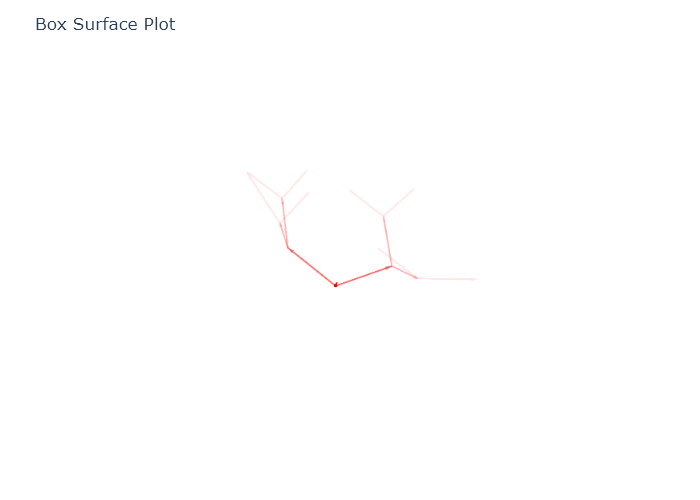

NaN

In [97]:
# Create initial ray with full amplitude
initial_ray = Ray([0.0, 0.0, 0.0], [1.0, 1.0, 1.0], 1.0)
root = TrajectoryNode(initial_ray, [])
trajectory = Trajectory(root)

# Generate rays up to 3 levels deep
generate_rays!(root, 3)

# Plot the complex ray trajectory
# plot_trajectory(trajectory; color="rgba($(rand(0:255)), $(rand(0:255)), $(rand(0:255)), 1)")
plot_trajectory(trajectory; color="rgba(255,0,0,1)")
